This homework assignment guides you through building and evaluating machine learning models to predict individual income using the American Community Survey (ACS) microdata. You will implement both an XGBoost model and a fully connected neural network using Keras, following the workflows demonstrated in the provided tutorials. The focus will be on log-transforming the income target, feature engineering, model training, and evaluation.

## Setup

### Data
Use the ACS microdata file `usa_00005.dta` that I shared on Populi. This dataset contains individual-level records with demographic and socioeconomic features, including total personal income (`inctot`).

## Task 1: Load and Log-transform ACS Data

Following the final attempt in the XGBoost tutorial, sample 10% of the microdata, drop any rows where `inctot == 9999999`.

In [86]:
import pandas as pd
data = pd.read_stata(r"C:\Users\ctao\OneDrive - RAND Corporation\Desktop\Class\Machine Learning\Machine_Learning_2025\data\raw\usa_00005.dta")
data = data.sample(frac=0.1, random_state=42).reset_index(drop=True) # subset to 10% of the data
y = data['inctot']
X = data.drop(columns=['inctot']) # all other variables are features
missing_val = 9999999
mask = (y != missing_val)
X = X[mask]
y = y[mask]

__Quesion 1:__ Why is it not necessary to impute or filter our missing values for other features?

Answer: The descision tree model already handles missing values by categorizing/sorting them within the model.

### Task 1.1: Log-transform Income

Instead of predicting income directly, we will predict log-income.
Create a new target column `log_inctot` by applying the natural log transformation to `inctot` after adding 1 (i.e., `np.log1p`).
Filter out any rows where `inctot` is less than or equal to zero before applying the log transformation.
Make a histogram of both the original income and log-income distributions to visualize the effect of the transformation.

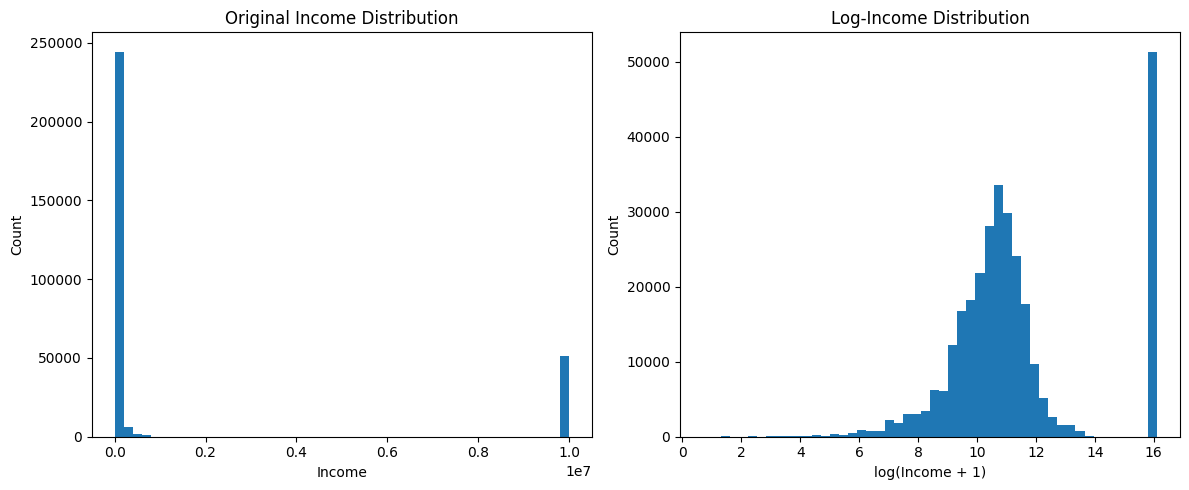

In [87]:
import matplotlib.pyplot as plt
import numpy as np
data = data[data["inctot"] > 0].copy() # Filter out non-positive inc
data["log_inctot"] = np.log1p(data["inctot"])

plt.figure(figsize=(12,5)) # 3. Plot hists
plt.subplot(1, 2, 1)
plt.hist(data["inctot"], bins=50)
plt.title("Original Income Distribution")
plt.xlabel("Income")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(data["log_inctot"], bins=50)
plt.title("Log-Income Distribution")
plt.xlabel("log(Income + 1)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

__Question 2:__ What are the advantages of predicting log-income rather than income directly?

Answer: Log income allows for the information to be displayed more clearly, since an absolute scale drowns out smaller values with the exponentially increasing hights of the distribution.

## Task 2: Feature Engineering and Encoding
Split the data into a feature matrix `X` and target vector `y` (the log-income column created above). Perform one-hot encoding on all categorical features, dropping sparse columns whose proportion of non-zero entries falls below 1%.

The feature matrix `X` should include all columns except `inctot` and `log_inctot`.
The target vector `y` should be the `log_inctot` column.
Mimic the one-hot encoding workflow from the tutorial: build dummies for every categorical column in `X`, then drop sparse columns whose proportion of non-zero entries falls below 1%.


In [ ]:
X = data.drop(columns=['inctot','log_inctot','cbserial','cluster','serial','countyfip']) #Caused neural network to fail
y = data['log_inctot']

X_encoded = pd.get_dummies(X, drop_first=False)
cols_to_keep = [col for col in X_encoded.columns if (X_encoded[col] != 0).mean() > 0.01]
X_encoded = X_encoded[cols_to_keep]

### Task 2.1: Train/Test Split
Split the encoded data into training and testing sets (80/20).

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
#print(X_train.max()) # Check for huge values

## Task 3: XGBoost Modeling (Log Target)
Reproduce the final modeling attempt from `examples/XGBoost.ipynb`, but treat the log-income target as the label. Work through the following subtasks and insert your own code in each block.


In [91]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

### Task 3.2: Hyperparameter Dictionary
Start from the tutorial’s baseline settings (e.g., `eta = 1`, `max_depth = 10`, `min_child_weight = 100`, RMSE metric, early stopping after 50 rounds) and justify any deviations you make.
Use the `reg:squarederror` objective and `rmse` evaluation metric.

In [ ]:
params = {'eta': 1, 'max_depth': 10, 'min_child_weight': 100, 'objective': 'reg:squarederror',
    'eval_metric': 'rmse', 'verbosity': 2}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 10000
early_stopping_rounds = 50

In [93]:
bst = xgb.train(params,dtrain,num_round,evallist,
        early_stopping_rounds=early_stopping_rounds)

c:\Users\ctao\OneDrive - RAND Corporation\Desktop\Class\Machine Learning\Machine_Learning_2025\venv\Lib\site-packages\xgboost\core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:0.80081	eval-rmse:0.80896
[1]	train-rmse:0.78008	eval-rmse:0.79252
[2]	train-rmse:0.76797	eval-rmse:0.78615
[3]	train-rmse:0.76146	eval-rmse:0.78235
[4]	train-rmse:0.75376	eval-rmse:0.78081
[5]	train-rmse:0.74910	eval-rmse:0.77840
[6]	train-rmse:0.74559	eval-rmse:0.77990
[7]	train-rmse:0.74142	eval-rmse:0.78152
[8]	train-rmse:0.73832	eval-rmse:0.78279
[9]	train-rmse:0.73638	eval-rmse:0.78335
[10]	train-rmse:0.73277	eval-rmse:0.78292
[11]	train-rmse:0.72970	eval-rmse:0.78433
[12]	train-rmse:0.72771	eval-rmse:0.78587
[13]	train-rmse:0.72544	eval-rmse:0.78717
[14]	train-rmse:0.72217	eval-rmse:0.78758
[15]	train-rmse:0.71868	eval-rmse:0.78807
[16]	train-rmse:0.71679	eval-rmse:0.78823
[17]	train-rmse:0.71426	eval-rmse:0.78834
[18]	train-rmse:0.71222	eval-rmse:0.78869
[19]	train-rmse:0.71064	eval-rmse:0.78933
[20]	train-rmse:0.70781	eval-rmse:0.79085
[21]	train-rmse:0.70551	eval-rmse:0.79183
[22]	train-rmse:0.70389	eval-rmse:0.79286
[23]	train-rmse:0.70264	eval-rmse:0.79364
[2

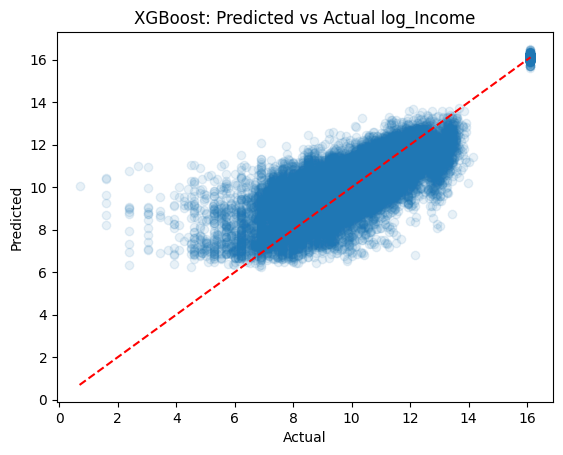

In [94]:
y_pred_plt = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
y_test_plt = y_test

# y_plt_pred = np.log(y_pred)
# y_plt_test = np.log(y_test)

plt.scatter(y_test_plt, y_pred_plt, alpha=0.1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Predicted vs Actual log_Income")
plt.plot([y_test_plt.min(), y_test_plt.max()], [y_test_plt.min(), y_test_plt.max()], 'r--')  # diagonal line
plt.show()

### Task 3.3: Hyperparameter Tuning

Perform a grid search over the `eta = [1, 0.1, 0.01]` and `max_depth = [3, 6, 10]` parameters to identify the best combination based on validation RMSE (i.e., for each combination of `eta` and `max_depth`, train a model and record the validation RMSE).
Use early stopping with a patience of 50 rounds and a maximum of 10,000 training rounds.

Training with eta=0.01
[0]	train-rmse:2.42197	eval-rmse:2.43409
[1]	train-rmse:2.40042	eval-rmse:2.41247
[2]	train-rmse:2.37912	eval-rmse:2.39108
[3]	train-rmse:2.35805	eval-rmse:2.36994
[4]	train-rmse:2.33721	eval-rmse:2.34902
[5]	train-rmse:2.31661	eval-rmse:2.32834
[6]	train-rmse:2.29623	eval-rmse:2.30789
[7]	train-rmse:2.27608	eval-rmse:2.28767
[8]	train-rmse:2.25616	eval-rmse:2.26767
[9]	train-rmse:2.23645	eval-rmse:2.24789
[10]	train-rmse:2.21695	eval-rmse:2.22831
[11]	train-rmse:2.19768	eval-rmse:2.20896
[12]	train-rmse:2.17862	eval-rmse:2.18982
[13]	train-rmse:2.15978	eval-rmse:2.17091
[14]	train-rmse:2.14113	eval-rmse:2.15218
[15]	train-rmse:2.12271	eval-rmse:2.13369
[16]	train-rmse:2.10450	eval-rmse:2.11542
[17]	train-rmse:2.08649	eval-rmse:2.09735
[18]	train-rmse:2.06869	eval-rmse:2.07948
[19]	train-rmse:2.05108	eval-rmse:2.06181
[20]	train-rmse:2.03367	eval-rmse:2.04432
[21]	train-rmse:2.01647	eval-rmse:2.02707
[22]	train-rmse:1.99946	eval-rmse:2.00999
[23]	train-rmse:1.982

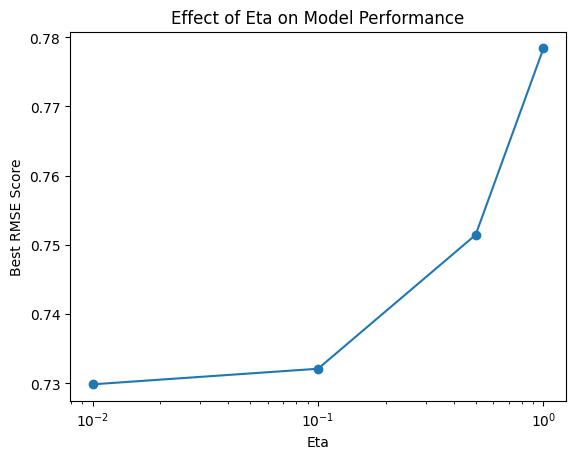

In [95]:
etas = [0.01, 0.1, 0.5, 1]
models = {}
for eta in etas:
    params = {'eta': eta,
        'max_depth': 10,
        'min_child_weight': 100,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'verbosity': 1}

    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    num_round = 10000
    early_stopping_rounds = 50

    print(f"Training with eta={eta}")
    bst = xgb.train(params, dtrain, num_round, evallist,
        early_stopping_rounds=early_stopping_rounds)
    models[eta] = bst

scores = [models[eta].best_score for eta in etas]
plt.plot(etas, scores, marker='o')
plt.xscale('log')
plt.xlabel('Eta')
plt.ylabel('Best RMSE Score')
plt.title('Effect of Eta on Model Performance')
plt.show()

__Question 3:__ Which hyperparameter combination yielded the lowest validation RMSE, and what was that RMSE value?
Based on the results, do you think you need to expand the grid search other values or parameters?
(Note: You do not need to actually search for more parameters, just discuss.)

Answer: The best RMSE score is the lowest at 0.73, obtained with a hyperparameter of 0.01. Based on the result, I don't think a further search is necessarily required. A RMSE of 0.7 says that the residuals are fairly small already, and further adjustment could simply lead to overfitting or extra time consumed.

### Task 3.4: Final Model Training
Using the best hyperparameters from Task 3.3, train a final XGBoost model on the full dataset.

In [96]:
params = {'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 100,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 2}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 10000
early_stopping_rounds = 50

bst = xgb.train(params,dtrain,num_round,evallist,
        early_stopping_rounds=early_stopping_rounds)

y_pred_plt = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
y_test_plt = y_test

[0]	train-rmse:2.42197	eval-rmse:2.43409
[1]	train-rmse:2.40042	eval-rmse:2.41247
[2]	train-rmse:2.37912	eval-rmse:2.39108
[3]	train-rmse:2.35805	eval-rmse:2.36994
[4]	train-rmse:2.33721	eval-rmse:2.34902
[5]	train-rmse:2.31661	eval-rmse:2.32834
[6]	train-rmse:2.29623	eval-rmse:2.30789
[7]	train-rmse:2.27608	eval-rmse:2.28767
[8]	train-rmse:2.25616	eval-rmse:2.26767
[9]	train-rmse:2.23645	eval-rmse:2.24789
[10]	train-rmse:2.21695	eval-rmse:2.22831
[11]	train-rmse:2.19768	eval-rmse:2.20896
[12]	train-rmse:2.17862	eval-rmse:2.18982
[13]	train-rmse:2.15978	eval-rmse:2.17091
[14]	train-rmse:2.14113	eval-rmse:2.15218
[15]	train-rmse:2.12271	eval-rmse:2.13369
[16]	train-rmse:2.10450	eval-rmse:2.11542
[17]	train-rmse:2.08649	eval-rmse:2.09735
[18]	train-rmse:2.06869	eval-rmse:2.07948
[19]	train-rmse:2.05108	eval-rmse:2.06181
[20]	train-rmse:2.03367	eval-rmse:2.04432
[21]	train-rmse:2.01647	eval-rmse:2.02707
[22]	train-rmse:1.99946	eval-rmse:2.00999
[23]	train-rmse:1.98264	eval-rmse:1.99310
[2

### Task 3.5: Evaluate Predictions
Plot predicted vs. actual log-income values on the test set using a scatter plot.

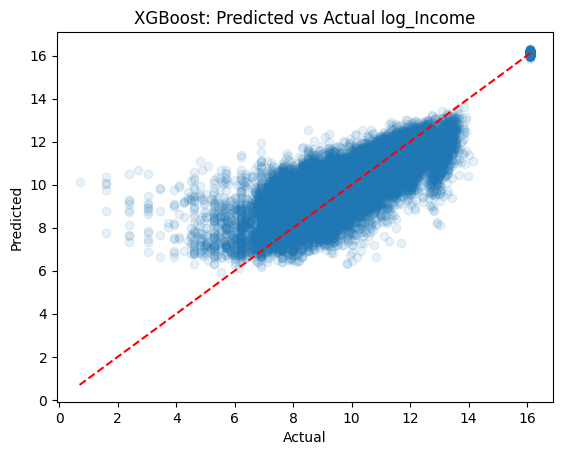

In [97]:
plt.scatter(y_test_plt, y_pred_plt, alpha=0.1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Predicted vs Actual log_Income")
plt.plot([y_test_plt.min(), y_test_plt.max()], [y_test_plt.min(), y_test_plt.max()], 'r--')  # diagonal line
plt.show()

__Question 4:__ Qualitatively, how well do the predictions align with the actual values?

The predictions and outcomes align reasonably well. There is somewhat of an ellipse rather than a full correlation. But too small an error would be a sign of overfitting, so the model appears fairly strong.

## Task 4: Neural Network Modeling (Keras)
Use the structure from `examples/neural_nets_simple.ipynb` to fit a fully connected neural network on the same encoded features and log-income target.
Use the same train/test split as in Task 2.1.

### Task 4.1: Prepare Data for Keras
If necessary, convert the training and test feature matrices and target vectors into NumPy arrays suitable for Keras.
__Note:__ You may have already done this in Task 2.1.

In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [111]:
'''print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(y_train.isna().sum())
print(y_train.isna().sum())

print(np.nanmax(np.abs(X_train.to_numpy())))
print(np.nanmin(np.abs(X_train.to_numpy())))
print(float(y_train.max()),float(y_train.min()))'''

'print(X_train.isna().sum().sum())\nprint(X_test.isna().sum().sum())\nprint(y_train.isna().sum())\nprint(y_train.isna().sum())\n\nprint(np.nanmax(np.abs(X_train.to_numpy())))\nprint(np.nanmin(np.abs(X_train.to_numpy())))\nprint(float(y_train.max()),float(y_train.min()))'

In [100]:
# Convert to numpy and float32
from sklearn.preprocessing import StandardScaler

'''X_train_np = X_train.to_numpy().astype('float32')
X_test_np = X_test.to_numpy().astype('float32')
y_train_np = y_train.to_numpy().astype('float32')
y_test_np = y_test.to_numpy().astype('float32')'''
X_train_np = X_train.values.astype('float32')
X_test_np = X_test.values.astype('float32')
y_train_np = y_train.values.astype('float32')
y_test_np = y_test.values.astype('float32')
model = keras.Sequential([layers.Dense(256, activation="relu", input_shape=(X_train.shape[1],)),  # input layer
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)]) # output layer for regression
#model.compile(learning_rate=0.001,optimizer='adam', loss='mse')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')


c:\Users\ctao\OneDrive - RAND Corporation\Desktop\Class\Machine Learning\Machine_Learning_2025\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


__Question 5:__ What should the input dimension be for the first layer of the network be? 

Answer: The input dimension should be the same as the number of columns of the training/testing data (X).

### Task 4.3: Initial Training
Fit the model on the training data while validating on the test set.
Run the training for a maximum of 1,000 epochs.
I have some example code below that includes early stopping to prevent overfitting.
You may adjust as needed.

The `patience` parameter in the `EarlyStopping` callback controls how many epochs with no improvement on the validation loss to wait before stopping training.
The `batch_size` is a parameter that we haven't discussed in class, but it limits the amount of data the model is exposed to at once during training.
You can leave it at 1024 for this assignment.

In [101]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)

history = model.fit(X_train_np, y_train_np, validation_data=(X_test_np, y_test_np),
    epochs=1000,batch_size=1024,verbose=1,callbacks=[early_stop])


Epoch 1/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 13013476.0000 - val_loss: 16058.2900
Epoch 2/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 7652.8672 - val_loss: 4657.8569
Epoch 3/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 4009.0630 - val_loss: 3149.1641
Epoch 4/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 5187.0679 - val_loss: 7341.3843
Epoch 5/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 12976.1758 - val_loss: 15234.3242
Epoch 6/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 22428.1211 - val_loss: 5425.2231
Epoch 7/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 51457.3906 - val_loss: 127589.6016
Epoch 8/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 346643.0625 - val_loss: 38935.5430
Epoch 9/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 405058.4688 - val_loss: 7115.6055
Epoch 10/1000
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 2223.9219 - val_loss: 1559.3309
Epoch 11/1000
239/239 ━━━━━━━━━━━

#### Task 4.3a
Plot the training and validation loss curves over epochs.

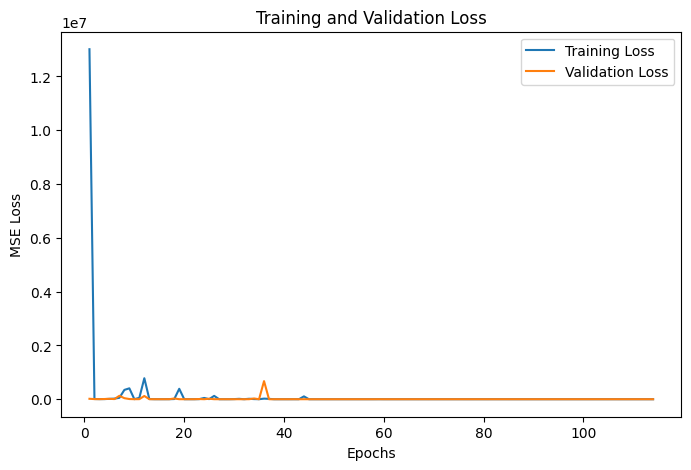

In [102]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

__Question 6:__ Based on the loss curves, does the model appear to be underfitting, overfitting, or well-fitted? Justify your answer.

The sharp decrease in MSE Loss at the start and slight fluctuations in validation loss suggest we may be slightly overfitting the model, but it is likely attributable to noise. A large decrease in trainng loss followed by a stable near zero validation loss is expected of a well fit model, since it shows that the model has stopped improving without an increase in validation problems.

### Task 4.4: Model Tuning
The neural network architecture and training parameters can significantly impact performance.
The architecture consists of the number of layers, layer dimensions, and activation functions.
Create three different architectures: the one from Task 4.2, a deeper/wider one, and a shallower/narrower one.
Additionally, consider three different learning rates: `1e-3`, `1e-4`, and `1e-5`.

Perform a grid search over these architectures and learning rates to identify the best combination based on validation loss.

__Hint:__ Save the models and their histories in a dictionary for easy comparison later.

In [ ]:
architectures = {
    "large": [256, 128, 64],
    "medium": [128, 64],
    "small": [64, 32]}
learning_rates = [1e-3, 1e-4,1e-5]
results = {}

for arch_name, layers_dims in architectures.items():
    for lr in learning_rates:

        model = keras.Sequential()
        model.add(layers.Dense(layers_dims[0], activation="relu", input_shape=(X_train_np.shape[1],)))
        for dim in layers_dims[1:]:
            model.add(layers.Dense(dim, activation="relu"))
        model.add(layers.Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')

        early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

        history = model.fit(
            X_train_np, y_train_np,
            validation_data=(X_test_np, y_test_np),
            epochs=50, batch_size=512,
            verbose=0, callbacks=[early_stop])
        results[(arch_name, lr)] = {"model": model, "history": history}
        print(f"Trained {arch_name} lr={lr} best val_loss={min(history.history['val_loss']):.4f}")

Trained large lr=0.001 best val_loss=20.7232
Trained large lr=0.0001 best val_loss=507.1643
Trained large lr=1e-05 best val_loss=1189.4020
Trained medium lr=0.001 best val_loss=196.9924
Trained medium lr=0.0001 best val_loss=1491.2653
Trained medium lr=1e-05 best val_loss=1133.3677
Trained small lr=0.001 best val_loss=92.3848
Trained small lr=0.0001 best val_loss=1545.4082
Trained small lr=1e-05 best val_loss=1089.4309


In [107]:
best_val_loss = np.inf
best_model = None
best_config = None

for config, result in results.items():
    val_loss = min(result['history'].history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = result['model']
        best_config = config

print(f"Best model: {best_config}, val_loss={best_val_loss:.4f}")

Best model: ('large', 0.001), val_loss=20.7232


__Question 7:__ Which architecture and learning rate combination yielded the lowest validation loss, and what was that loss value?

The lowest validation loss was achieved by the large model with learning rate = 0.001. It achieved a loss of 20.7232

### Task 4.5: Evaluate Predictions
Generate predictions on the test set using the best model from Task 4.
Create a scatter plot of predicted vs. actual log-income values.

1908/1908 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


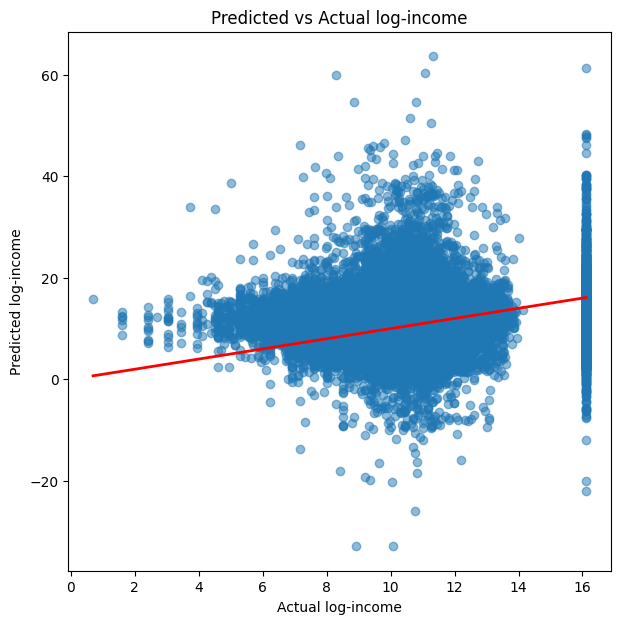

In [109]:
y_pred = best_model.predict(X_test_np).flatten()
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()],
         [y_test_np.min(), y_test_np.max()],
         color='red', linewidth=2)  # 45-degree line for perfect prediction
plt.xlabel('Actual log-income')
plt.ylabel('Predicted log-income')
plt.title('Predicted vs Actual log-income')
plt.show()

## Task 5: Model Comparison and Reflection
Which model would you choose for predicting log-income on new ACS data: the XGBoost model from Task 3 or the neural network from Task 4? Why?

Answer: I would choose the xgboost descision tree model. It displayed a smaller error (rmse = ~0.7 vs ~sprt(20)~4), and took significantly less time to train vs the neural net. It makes up for its lack of complexity by being more robust and easier to handle.